<a href="https://colab.research.google.com/github/chinu1997/Capstone-4-Team-3-/blob/main/Chinmaya_Devprasad_of_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=b3b0870909d6680c70bd598d30db49e663f46ee05cba2f51d1720f020baad351
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
News=[]
Type=[]

path="/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-4/Topic Modeling on BBC News Articles/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)
      

data={'news':News,'type':Type}
df = pd.DataFrame(data)

In [ ]:
df.head()

,news,type
0,b'Mixed signals from French economy\n\nThe Fre...,business
1,b'US trade gap hits record in 2004\n\nThe gap ...,business
2,b'Indonesians face fuel price rise\n\nIndonesi...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,b'Sluggish economy hits German jobs\n\nThe num...,business


In [ ]:
df.shape

(2225, 2)

Text(0.5, 1.0, 'Type Of news Counts')

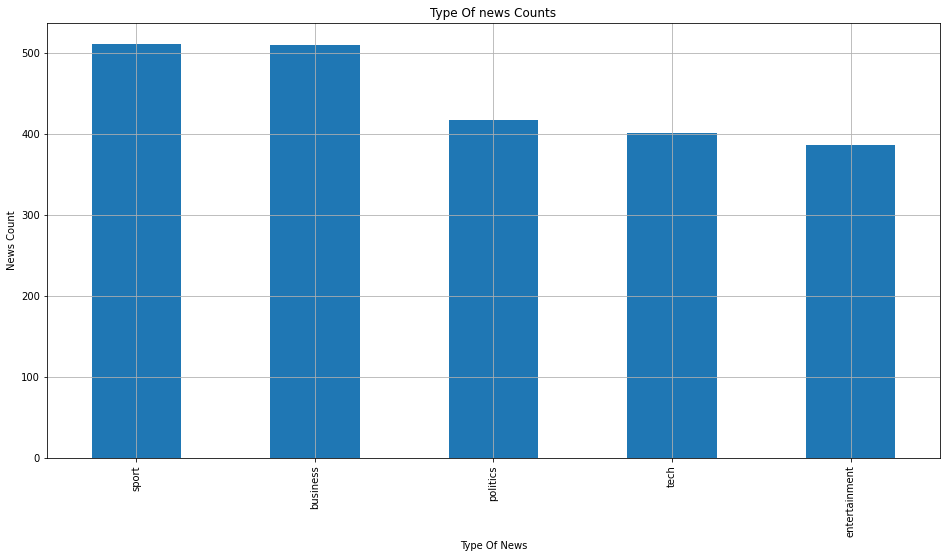

In [ ]:
plt.figure(figsize=(16,8))
df['type'].value_counts().plot(kind='bar',grid=True)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")

In [ ]:
df['news'][0]

b'Mixed signals from French economy\n\nThe French economy picked up speed at the end of 2004, official figures show - but still looks set to have fallen short of the government\'s hopes.\n\nAccording to state statistics body INSEE, growth for the three months to December was a seasonally-adjusted 0.7-0.8%, ahead of the 0.6% forecast. If confirmed, that would be the best quarterly showing since early 2002. It leaves GDP up 2.3% for the full year, but short of the 2.5% which the French government had predicted.\n\nDespite the apparent shortfall in annual economic growth, the good quarterly figures - a so-called "flash estimate" - mark a continuing trend of improving indicators for the health of the French economy. The government is reiterating a 2.5% target for 2005, while the European Central Bank is making positive noises for the 12-nation eurozone as a whole. Also on Friday, France\'s industrial output for December was released, showing 0.7% growth. "The numbers are good," said David 

In [ ]:
df['news'] = df['news'].astype('str') 

In [ ]:
stop_list=list(stopwords.words('english'))
stop_list.append('would')
stop_list.append('could')


In [ ]:
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stop_list]
  return ' '.join(main_text)

In [ ]:

def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [ ]:
df['news']=df['news'].apply(Change_text)

In [ ]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

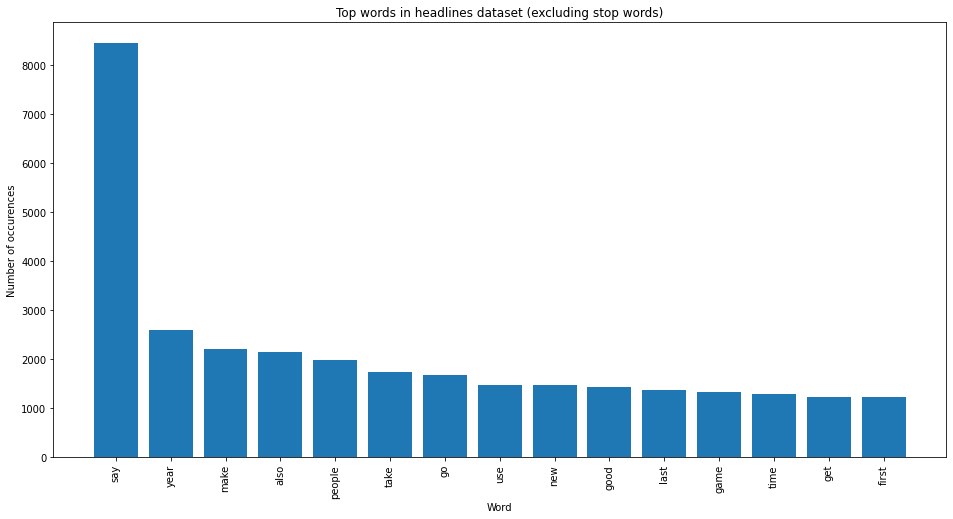

In [ ]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

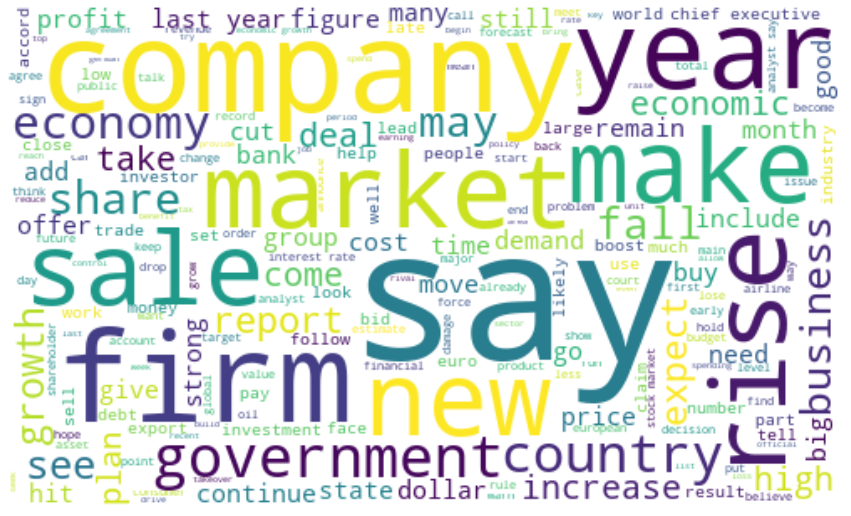

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

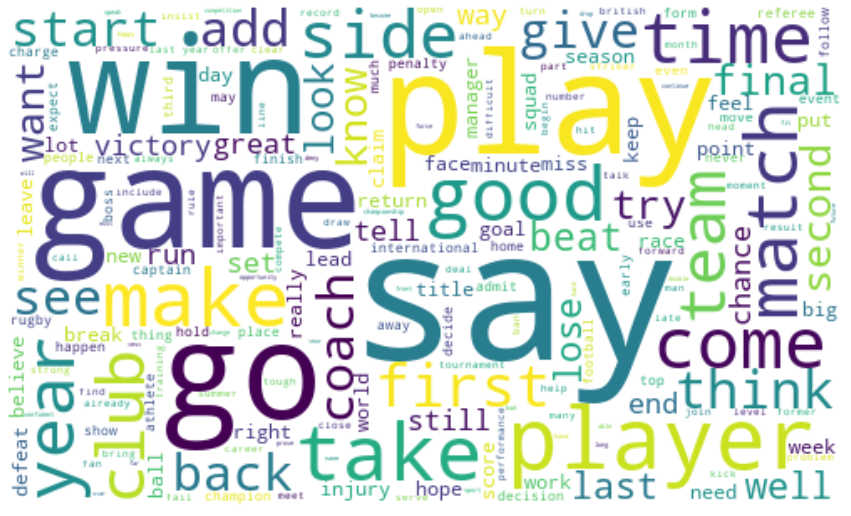

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000,min_df=0.05)

In [ ]:
matrix=vectorizer.fit_transform(df['news'])

In [ ]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [ ]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,affect,age,ago,agree,ahead,aim,allow,almost,already,also,always,amount,analyst,announce,annual,appear,area,argue,ask,attack,attempt,available,average,avoid,award,away,back,bad,base,battle,...,thing,think,third,time,title,today,together,top,total,tough,trade,trial,try,turn,tv,understand,use,user,value,version,victory,video,view,vote,want,warn,watch,way,website,week,well,whole,win,winner,work,world,write,year,yet,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.120559,0.0,0.000000,0.0,0.000000,0.057281,0.0,0.0,0.000000,0.0,0.140269,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.087720,0.0,0.0,0.000000,0.139711,0.0,0.0,0.000000,0.000000,0.0,0.056878,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106427,0.0,0.0,0.0,0.000000,0.0,0.080769,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.097177,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.065200,0.0,0.0,0.0,...,0.080769,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.299946,0.0,0.000000,0.082158,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.065049,0.0,0.125185,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.033789,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.078133,0.0,0.000000,0.078538,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.043061,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.059917,0.000000,0.0,0.0,0.047868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098238,0.000000,0.0,0.000000,0.0,0.0,0.051354,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.067102,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083357,0.0,0.000000,0.0,0.000000,0.039605,0.0,0.0,0.161756,0.0,0.096985,0.0,0.0,0.000000,0.0,0.088075,0.000000,0.0,0.100524,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.075699,0.000000,0.0,0.0,0.0,0.000000,0.091117,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084516,0.0,0.060651,0.0,0.0,0.060195,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.157306,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105603,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.074086,0.041699,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.064695,0.0,0.0,0.0,...,0.000000,0.0,0.079700,0.000000,0.0,0.0,0.0,0.149471,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.122453,0.000000,0.0,0.041405,0.0,0.0


In [ ]:
model=LatentDirichletAllocation(n_components=5)
model.fit(matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  47.249128
3       51.163364 -159.968018       2        1  22.781127
0      -73.144554   21.523815       3        1  15.785123
4      -66.410133 -110.606438       4        1   9.744332
2       54.417324   12.443444       5        1   4.440290, topic_info=      Term       Freq       Total Category  logprob  loglift
157   film  87.000000   87.000000  Default  30.0000  30.0000
176   game  85.000000   85.000000  Default  29.0000  29.0000
287  music  54.000000   54.000000  Default  28.0000  28.0000
34   award  46.000000   46.000000  Default  27.0000  27.0000
387   sale  57.000000   57.000000  Default  26.0000  26.0000
..     ...        ...         ...      ...      ...      ...
296    new   4.980470   70.840461   Topic5  -4.7671   0.4595
182     go   4.969572   76.586967   Topic5  -4.7693   0.3794
483   year   4.884083  105.593985   Topic5  -4.7866   0.0408
421   star   3.703716   51.144302   Topic5  -5.0633   0.4891
19    also   3.772717   86.637316   Topic5  -5.0448  -0.0195

[248 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.872953  access
2         3  0.054560  access
6         1  0.377565     act
6         2  0.047196     act
6         3  0.047196     act
...     ...       ...     ...
483       1  0.312518    year
483       2  0.189405    year
483       3  0.284107    year
483       4  0.170464    year
483       5  0.047351    year

[652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [ ]:
df['length']=df['news'].apply(len)

In [ ]:
df.head(15)

,news,type,length
0,bmixe signal french economynnthe french econom...,business,701
1,gap hit record gap export import hit late figu...,business,1082
2,bindonesian face fuel price government confirm...,business,893
3,bhigh fuel price hit ba profitsnnbritish blame...,business,1307
4,bsluggish economy hit german number people wor...,business,1140
5,bair passenger win new passenger unable board ...,business,1943
6,user lose patiencenncustomer try call centre g...,business,2044
7,alert recall world big carmaker recall nearly ...,business,844
8,rupee hit rupee hit fiveyear high raise countr...,business,434
9,unit buyer face loan owner embattle russian oi...,business,801


In [ ]:
business = df[df['type'] == 'business']
entertainment = df[df['type'] == 'entertainment']
politics = df[df['type'] == 'politics']
sport = df[df['type'] == 'sport']
tech = df[df['type'] == 'tech']


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

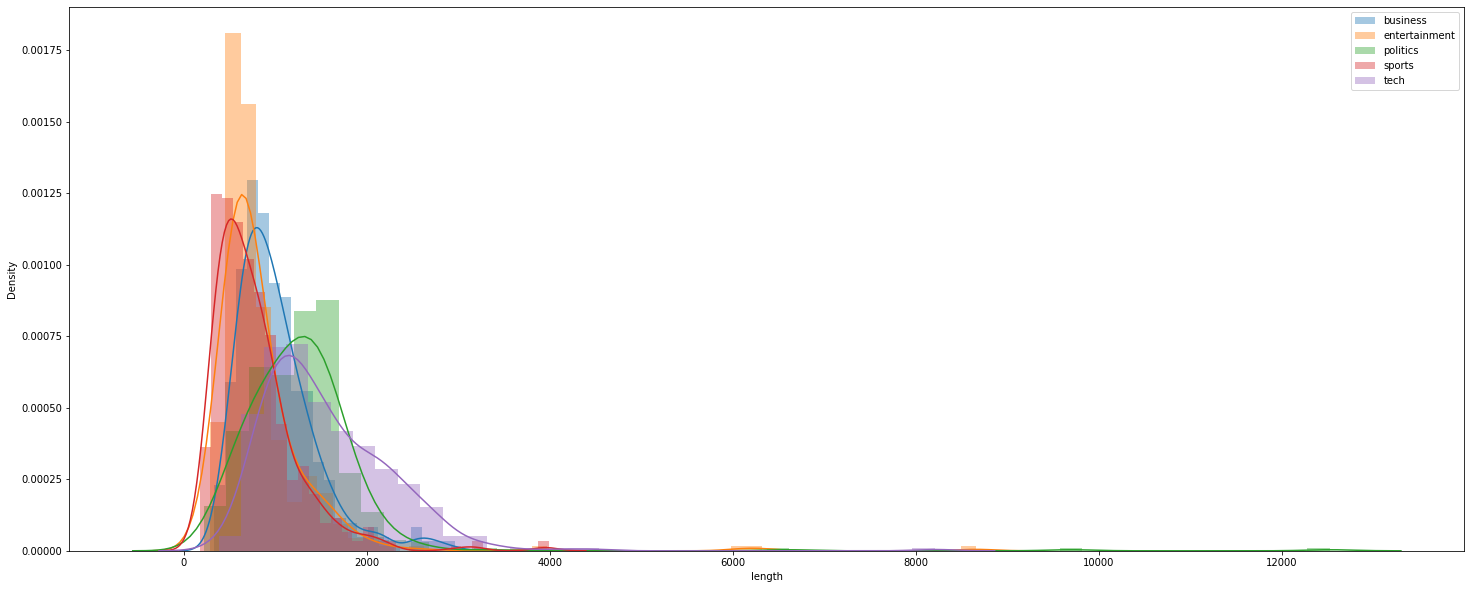

In [ ]:
fig = plt.figure(figsize=(25,10))
sns.distplot(df.loc[df['type'] == 'business', 'length'],label='business')
sns.distplot(df.loc[df['type'] == 'entertainment', 'length'],label='entertainment')
sns.distplot(df.loc[df['type'] == 'politics', 'length'],label='politics')
sns.distplot(df.loc[df['type'] == 'sport', 'length'],label='sports')
sns.distplot(df.loc[df['type'] == 'tech', 'length'],label='tech')

plt.legend()
plt.show()

In [ ]:
word_data=df['news'].str.split().tolist()

In [ ]:
id2word=corpora.Dictionary(word_data)
corpus=[id2word.doc2bow(text) for text in word_data]

In [ ]:
print(corpus[:120])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 4), (25, 1), (26, 2), (27, 3), (28, 3), (29, 1), (30, 2), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 3), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1)], [(11, 1), (13, 2), (14, 2), (15, 1), (21, 2), (26, 1), (28, 2), (31, 2), (54, 3), (69, 1), (73, 3), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 5), (98, 2), (99, 1), (100, 2

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('10n', 1),
  ('activity', 1),
  ('ahead', 1),
  ('also', 1),
  ('annual', 1),
  ('apparent', 1),
  ('best', 1),
  ('bmixe', 1),
  ('body', 1),
  ('confirm', 1),
  ('continuation', 1),
  ('continue', 1),
  ('early', 1),
  ('economic', 1),
  ('economist', 1),
  ('economy', 2),
  ('economynnthe', 1),
  ('end', 1),
  ('estimate', 1),
  ('eurozone', 1),
  ('fall', 1),
  ('figure', 2),
  ('flash', 1),
  ('forecast', 1),
  ('french', 4),
  ('full', 1),
  ('good', 2),
  ('government', 3),
  ('growth', 3),
  ('health', 1),
  ('high', 2),
  ('hit', 1),
  ('hopesnnaccorde', 1),
  ('improve', 2),
  ('indicator', 1),
  ('industrial', 1),
  ('leave', 1),
  ('look', 1),
  ('make', 1),
  ('mark', 1),
  ('month', 1),
  ('noise', 1),
  ('number', 1),
  ('official', 1),
  ('open', 1),
  ('output', 2),
  ('pick', 1),
  ('positive', 2),
  ('predictednndespite', 1),
  ('quarterly', 2),
  ('rebound', 1),
  ('reiterate', 1),
  ('release', 1),
  ('remain', 1),
  ('say', 1),
  ('seasonallyadjuste', 1),
  ('s

In [ ]:
import gensim

In [ ]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,update_every=1)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
import pyLDAvis.gensim

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.001363  0.041141       1        1  47.539819
4     -0.015785  0.014787       2        1  19.307060
0      0.001234  0.003157       3        1  15.002334
1     -0.041880 -0.035350       4        1  10.802264
3      0.055069 -0.023734       5        1   7.348524, topic_info=           Term         Freq        Total Category  logprob  loglift
54          say  6799.000000  6799.000000  Default  30.0000  30.0000
588       phone   992.000000   992.000000  Default  29.0000  29.0000
573      mobile  1142.000000  1142.000000  Default  28.0000  28.0000
239         use  2270.000000  2270.000000  Default  27.0000  27.0000
504  technology  1585.000000  1585.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
324        take   109.904128  1758.815411   Topic5  -5.4464  -0.1621
61         show    93.676391  1181.965655   Topic5  -5.6062   0.0756
118         get    84.207464  1456.636228   Topic5  -5.7127  -0.2399
576       music    81.415816  1325.314786   Topic5  -5.7465  -0.1792
236        time    82.733681  1588.961321   Topic5  -5.7304  -0.3445

[468 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
4664       1  0.947178  175bn
17950      1  0.304210  2005n
17950      2  0.101403  2005n
17950      4  0.101403  2005n
17950      5  0.507016  2005n
...      ...       ...    ...
73         3  0.148566   year
73         4  0.087654   year
73         5  0.065864   year
17984      1  0.175912   zoom
17984      4  0.703647   zoom

[1138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

In [ ]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(5):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.007s...
[t-SNE] Computed neighbors for 2225 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.055565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.013847
[t-SNE] KL divergence after 2000 iterations: 0.803793


In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:5]

In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(5):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, matrix, vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(5), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(5):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [ ]:
df['target'] = pd.factorize(df['type'])[0] + 1

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0],end=" ")
        

Topic 0: 
year make game also people go take Topic 1: 
game film play win good player award Topic 2: 
film award star director include movie good Topic 3: 
use phone mobile technology user people computer Topic 4: 
sale game market price rise growth fall 

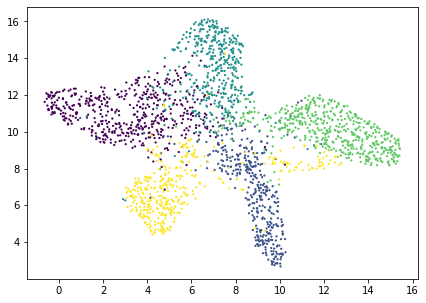

In [ ]:
import umap

X_topics = lsa_model.fit_transform(matrix)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = df.target,s = 5,edgecolor='none')
plt.show()


In [ ]:
df.head()

,news,type,length,target
0,bmixe signal french economynnthe french econom...,business,701,1
1,gap hit record gap export import hit late figu...,business,1082,1
2,bindonesian face fuel price government confirm...,business,893,1
3,bhigh fuel price hit ba profitsnnbritish blame...,business,1307,1
4,bsluggish economy hit german number people wor...,business,1140,1


In [ ]:
from gensim.models import Word2Vec
word2vec = Word2Vec(word_data, min_count=2)

In [ ]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

{'bmixe': <gensim.models.keyedvectors.Vocab object at 0x7f5766041cc0>, 'signal': <gensim.models.keyedvectors.Vocab object at 0x7f57660417f0>, 'french': <gensim.models.keyedvectors.Vocab object at 0x7f5766041588>, 'economy': <gensim.models.keyedvectors.Vocab object at 0x7f57660414e0>, 'pick': <gensim.models.keyedvectors.Vocab object at 0x7f5766041eb8>, 'speed': <gensim.models.keyedvectors.Vocab object at 0x7f57660416a0>, 'end': <gensim.models.keyedvectors.Vocab object at 0x7f5766041f28>, 'official': <gensim.models.keyedvectors.Vocab object at 0x7f57660414a8>, 'figure': <gensim.models.keyedvectors.Vocab object at 0x7f57660410b8>, 'show': <gensim.models.keyedvectors.Vocab object at 0x7f5766041438>, 'still': <gensim.models.keyedvectors.Vocab object at 0x7f5766041748>, 'look': <gensim.models.keyedvectors.Vocab object at 0x7f5766041400>, 'set': <gensim.models.keyedvectors.Vocab object at 0x7f57660419e8>, 'fall': <gensim.models.keyedvectors.Vocab object at 0x7f5766041470>, 'short': <gensim.mo

In [ ]:
sim_words = word2vec.wv.most_similar('tax')
for x in sim_words:
  print(x)

('cut', 0.9954033493995667)
('cost', 0.9902598261833191)
('income', 0.9890075922012329)
('spending', 0.9885048866271973)
('fuel', 0.9849740266799927)
('taxis', 0.9842008352279663)
('oil', 0.9827566146850586)
('increase', 0.9813539981842041)
('speed', 0.9812866449356079)
('share', 0.9809758067131042)


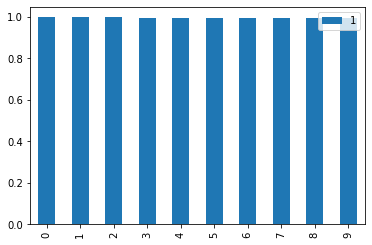

In [ ]:
word=pd.DataFrame(sim_words)
word.plot(kind='bar')